In [1]:
# OPTIONAL: Load the "autoreload" eX_orig[alias]tension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from scipy import stats
from matplotlib.lines import Line2D

from sklearn.covariance import MinCovDet
from sklearn.preprocessing import StandardScaler

from src.config import get_hussmann_supplementary_xlsx, HOME_PATH, FILTER_COUNT, METHOD, PROFILE_TYPE, SAMPLE, PAIRED_SAMPLES, get_experiment_artifacts
from src.models.outliers import logratio_outlier_detection
from src.util import calculate_difference_to_controls

In [3]:
rename_mutations = {
    "Any Insertion": "Ins",
    "Deletion 0bp microhomology": "NoMHDel",
    "Deletion 1bp microhomology": "1bpMHDel",
    "Deletion 2bp microhomology": "2bpMHDel",
    "Deletion 3+bp microhomology": "3+bpMHDel",
    "Deletion with insertion": "Delins",
    "Homology Directed Repair": "HDR",
    "Adamson_T1": "Repair-seq",
    "T1": "MUSIC T1",
    "T2": "MUSIC T2",
    "T3": "MUSIC T3",
}

In [4]:
sns.set_theme(style="white", palette="muted")
sns.set_context("paper", font_scale = 1.3)

import matplotlib as mpl

mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

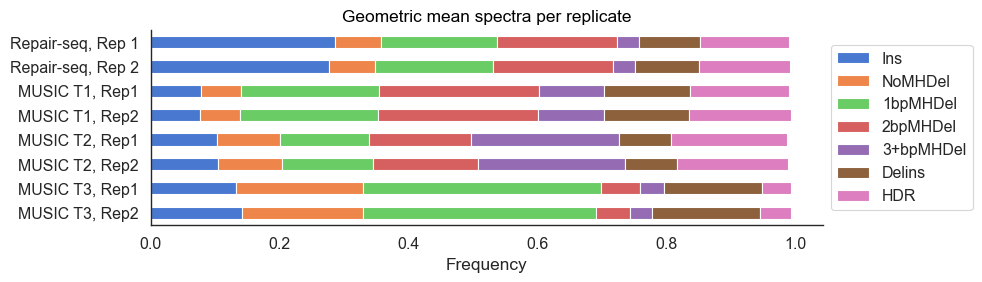

In [7]:
Z_sample = pkl.load(open("{}/imputed_adamson_sample_data.pkl"\
    .format(get_experiment_artifacts(profile_type=SAMPLE)), "rb"))

Z_sample.update(pkl.load(open("{}/imputed_sample_data.pkl"\
    .format(get_experiment_artifacts(profile_type=SAMPLE)), "rb")))

d_sample = pd.concat(Z_sample, axis=1).dropna()

Xall_sample = d_sample.stack().stack()\
    .to_frame().reset_index()\
    .rename(columns={"level_2": "Sample", 0: "Value"})\
    .pivot(index=["Sample", "Gene"], columns=["lumc_category"], values="Value")
Xall_sample.index.unique("Sample")
Xall_sample = Xall_sample.rename(columns=rename_mutations)


barplot_df = pd.DataFrame(Xall_sample.groupby("Sample").apply(stats.gmean).values.tolist(), index=Xall_sample.index.unique("Sample"), columns=Xall_sample.columns)
f = plt.figure(figsize=(10, 3))
plt.title('Geometric mean spectra per replicate', color='black')

barplot_df.plot(kind="barh", stacked=True, ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.yticks(np.arange(8), ['MUSIC T3, Rep2', 'MUSIC T3, Rep1',\
                          'MUSIC T2, Rep2', 'MUSIC T2, Rep1',\
                          'MUSIC T1, Rep2', 'MUSIC T1, Rep1',\
                          'Repair-seq, Rep 2', 'Repair-seq, Rep 1'])
plt.ylabel("")
plt.xlabel("Frequency")
# plt.text(0.02, 0.9, "A", transform=f.transFigure, 
#             size=20, weight='bold')
plt.tight_layout()
plt.savefig("artifacts/geometric_spectra.pdf")


In [8]:
Z_sample["K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1"].index.str.contains("non-").sum()

29

In [10]:
Z_sample = pkl.load(open("{}/imputed_adamson_sample_data.pkl"\
    .format(get_experiment_artifacts(profile_type=PAIRED_SAMPLES)), "rb"))
d_sample = pd.concat(Z_sample, axis=1)
target_sites = list(Z_sample.keys())
non_targetting_controls = d_sample.index.to_series()[d_sample.index.to_series().str.lower().str.contains("non-")]

In [11]:
non_targetting_controls.head()

Gene
non-targeting_00026    non-targeting_00026
non-targeting_00074    non-targeting_00074
non-targeting_00097    non-targeting_00097
non-targeting_00155    non-targeting_00155
non-targeting_00240    non-targeting_00240
Name: Gene, dtype: object

In [12]:
Z_paired = pkl.load(open("{}/imputed_adamson_sample_data.pkl".format(get_experiment_artifacts(profile_type=PAIRED_SAMPLES)), "rb"))
d_paired = pd.concat(Z_paired, axis=1).dropna()
# print(d_paired.shape)

Xall_paired = d_paired.stack().stack()\
    .to_frame().reset_index()\
    .rename(columns={"level_2": "Sample", 0: "Value"})\
    .pivot(index=["Sample", "Gene"], columns=["lumc_category"], values="Value")\
    .rename(columns=rename_mutations)
Xall_paired.index.unique("Sample")

idx = pd.IndexSlice
map_samples_to_target = {
    "K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1": "Adamson_T1",
    "K562_SpCas9_target-1_HDR_oBA701_AX227_rep_2": "Adamson_T1",
}

results = {}
for alias in Z_paired.keys():
    pca_scores, loadings, explained_variance_ratio, distances, pvalues, _ = \
        logratio_outlier_detection(d_paired[alias], MinCovDet(random_state=0))
    results[alias] = pca_scores, loadings, explained_variance_ratio, distances, pvalues
    results[alias] = pd.Series(distances, index=d_paired[alias].index).sort_values(ascending=False)

pseudo_controls = {}
for alias in Z_paired.keys():
    pseudo_controls[alias] = results[alias].iloc[-60:].index.to_series()
pseudo_controls[alias][:5]
non_targetting_controls = d_sample.index.to_series()[d_sample.index.to_series().str.lower().str.contains("non-")]

Xdiff = {}
alias = "Adamson_T1"
Xdiff["Pseudo"] = calculate_difference_to_controls(Xall_paired.loc[Xall_paired.index.get_level_values(0) == alias, :], pseudo_controls[alias], [alias])
Xdiff["Non-targeting"] = calculate_difference_to_controls(Xall_paired.loc[Xall_paired.index.get_level_values(0) == alias, :], non_targetting_controls, [alias])

Xdiff = pd.concat(Xdiff, axis=1).droplevel(axis=1, level=1)

(527, 7)
(60, 7)
(527, 7)
(7,)
(527, 7)
(527, 7)
(60, 7)
(527, 7)
(7,)
(527, 7)


In [13]:
Xdiff.apply(lambda x: np.corrcoef(x["Pseudo"], x["Non-targeting"])[0, 1], axis=1).mean()

0.9681838869635496

0.1602251553030303 0.13734074074074076 0.5030965113636361 0.05


/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_66981/2264941215.py:63: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


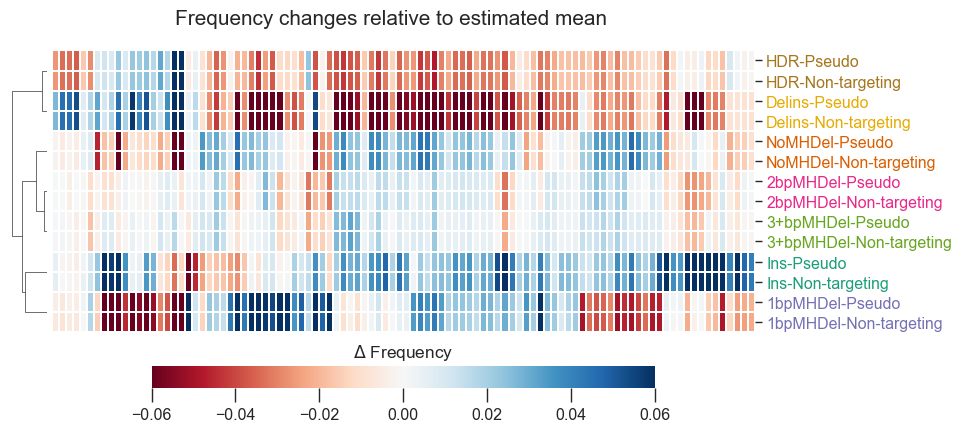

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

Xdiff.columns = Xdiff.columns.rename(["Controls", "Mutational Outcome"])

pvalues = pd.Series(pvalues, index=d_paired[alias].index)
top_genes = pvalues.sort_values()[:100].index.to_series()
Xdiff = Xdiff.loc[top_genes, :]

pal = sns.color_palette('Dark2', Xdiff.columns.get_level_values("Mutational Outcome").unique().shape[0])
lut = dict(zip(Xdiff.columns.get_level_values("Mutational Outcome").unique(), pal))
col_colors = Xdiff.columns.get_level_values("Mutational Outcome").to_series().map(lut)
col_colors.index = Xdiff.columns

kws = dict(cbar_kws=dict(orientation='horizontal'))
cg = sns.clustermap(Xdiff.T.reorder_levels(axis=0, order=[1,0]),
                    metric="correlation",
                    method="ward",
                    figsize=(10, 4.5),
                    cmap="RdBu",
                    vmax=0.06,
                    vmin=-0.06,
                    center=0,
                    dendrogram_ratio=(.05, 0.1),
                    linewidths=0.1,
                    linecolor='white',
                    # clip_on=False,
                    # colors_ratio = (1, 3),
                    cbar_pos=(0, 0, .02, .4),
                    xticklabels=True,
                    **kws
                    ) #left, bottom, width, height


cg.ax_col_dendrogram.set_visible(False)
cg.ax_heatmap.set_ylabel(None)
cg.ax_heatmap.set_xlabel("")
cg.ax_heatmap.set_xticklabels(["ha"]*100, color='white')

x0, _y0, _w, _h = cg.cbar_pos
_w = cg.ax_heatmap.get_position().width - 0.2
_h = 0.05
x0 = cg.ax_heatmap.get_position().xmin + 0.1
_y0 = cg.ax_heatmap.get_position().ymin - 0.125

print(x0, _y0, _w, _h)
cg.ax_cbar.set_position([x0, _y0, _w, _h])
cg.ax_cbar.set_title('$\Delta$ Frequency')
cg.ax_cbar.tick_params(axis='x', length=10)

for i, tick_label in enumerate(cg.ax_heatmap.axes.get_yticklabels()):
    tick_text = tick_label.get_text().split("-", 1)[0]
    tick_label.set_color(lut[tick_text])
    tick_label.set_rotation(0)

# for i, tick_label in enumerate(cg.ax_heatmap.axes.get_xticklabels()):
#     tick_label.set_rotation(90)


# plt.text(0.02, 2.75, "B", transform=f.transFigure, 
#             size=20, weight='bold')
plt.suptitle("Frequency changes relative to estimated mean", x=0.4)

plt.tight_layout()
plt.savefig("artifacts/clustermap_adamson.pdf")


In [15]:
import sklearn

# sklearn.metrics.mean_squared_error(Xdiff["Pseudo"], Xdiff["Non-targeting"])

np.diag(sklearn.metrics.pairwise_distances(Xdiff["Pseudo"], Xdiff["Non-targeting"], metric='correlation'))[0]

0.00029897586727323233

In [16]:
import pandas as pd
from src.config import get_interim_dir, get_experiment_artifacts
from src.models.outliers import outlier_detection, logratio_outlier_detection, impute_zero_values
from src.config import get_hussmann_supplementary_xlsx, HOME_PATH, FILTER_COUNT, METHOD, TARGETDIFF, SAMPLE, PAIRED_SAMPLES, PROFILE_TYPE

targets = ["MB01", "MB02", "MB03", "MB04", "MB05", "MB06"]

X_orig = {}
X_imputed = {}
counts = {}

for alias in targets:
    X = pd.read_pickle(get_interim_dir() + "{}_gRNAwise_all_repair_outcome_profiles.{}.pkl".format(alias, FILTER_COUNT))
    X = X.loc[:, (X != 0).any(axis=0)]
    print((X>0).sum().sum() / (X.shape[0] * X.shape[1]))

    counts[alias] = X.sum(axis=1)

    X_orig[alias] = X

    X = impute_zero_values(X, 1)
    columns = X.columns
    # X = X.div(X.sum(axis=1), axis=0)
    X = X.groupby(["Gene"]).apply(stats.gmean)
    X = pd.DataFrame(X.values.tolist(), index=X.index, columns=columns)
    X = X.div(X.sum(axis=1), axis=0)
    X.columns = columns

    X_imputed[alias] = X

print("Data Ready.")

0.9937929183349363
0.00 of our data is zero
0.9935922525524753
0.00 of our data is zero
0.9959820829954473
0.00 of our data is zero
0.9954643204383372
0.00 of our data is zero
0.9927946367701835
0.00 of our data is zero
0.9930757121463217
0.00 of our data is zero
Data Ready.


In [ ]:
def calculate_differential_profile(alias1, alias2, X_imputed):
    print("There are {} genes in {}".format(X_imputed[alias1].shape[0], alias1))
    print("There are {} genes in {}".format(X_imputed[alias1].shape[0], alias2))
    a = X_imputed[alias1]
    b = X_imputed[alias2]
    
    X = pd.concat([a, b], axis=0)
    columns = X.columns
    X = X.groupby(["Gene"]).apply(stats.gmean)
    X = pd.DataFrame(X.values.tolist(), index=X.index, columns=columns)
    X = X.div(X.sum(axis=1), axis=0)

    Z_case = X
    print("There are {} cases".format(Z_case.shape[0]))

    return Z_case

Z_paired = {}

Z_paired["T1"] = calculate_differential_profile("MB01", "MB02", X_imputed)
Z_paired["T2"] = calculate_differential_profile("MB03", "MB04", X_imputed)
Z_paired["T3"] = calculate_differential_profile("MB05", "MB06", X_imputed)

print(Z_paired["T1"].shape[0], Z_paired["T2"].shape[0], Z_paired["T3"].shape[0])

There are 18406 genes in MB01
There are 18406 genes in MB02
There are 18406 cases
There are 18406 genes in MB03
There are 18406 genes in MB04
There are 18406 cases
There are 18406 genes in MB05
There are 18406 genes in MB06


In [15]:
Z_paired.update(pkl.load(open("{}/imputed_adamson_sample_data.pkl".format(get_experiment_artifacts(profile_type=PAIRED_SAMPLES)), "rb")))
d_paired = pd.concat(Z_paired, axis=1).dropna()
print(d_paired.shape)

Xall_paired = d_paired.stack().stack()\
    .to_frame().reset_index()\
    .rename(columns={"level_2": "Sample", 0: "Value"})\
    .pivot(index=["Sample", "Gene"], columns=["lumc_category"], values="Value")\
    .rename(columns={"Any Insertion": "Insertion"})
Xall_paired.index.unique("Sample")

(434, 28)


Index(['Adamson_T1', 'T1', 'T2', 'T3'], dtype='object', name='Sample')

In [16]:
results = {}
for alias in Z_paired.keys():
    pca_scores, loadings, explained_variance_ratio, distances, pvalues, _ = \
        logratio_outlier_detection(d_paired[alias], MinCovDet(random_state=0))
    results[alias] = pca_scores, loadings, explained_variance_ratio, distances, pvalues
    results[alias] = pd.Series(distances, index=d_paired[alias].index).sort_values(ascending=False)

In [17]:
all_results = pd.concat(results, axis=1)

all_results = pd.DataFrame(StandardScaler().fit_transform(all_results.values), index=all_results.index, columns=all_results.columns)
top_genes = all_results.mean(axis=1).sort_values()[-100:].index.to_list()

In [18]:
pseudo_controls = {}
for alias in Z_paired.keys():
    pseudo_controls[alias] = results[alias].iloc[-60:].index.to_series()
pseudo_controls[alias][:5]

Gene
Keap1    Keap1
Chd4      Chd4
Cbx4      Cbx4
Ring1    Ring1
Apex2    Apex2
Name: Gene, dtype: object

In [19]:
idx = pd.IndexSlice
map_samples_to_target = {
    "K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1": "Adamson_T1",
    "K562_SpCas9_target-1_HDR_oBA701_AX227_rep_2": "Adamson_T1",
    "MB01": "T1",
    "MB02": "T1",
    "MB03": "T2",
    "MB04": "T2",
    "MB05": "T3",
    "MB06": "T3",
}

Xpseudodiff = {}
for alias in Z_paired.keys():
    Xpseudodiff[alias] = calculate_difference_to_controls(Xall_paired.loc[Xall_paired.index.get_level_values(0) == alias, :], pseudo_controls[alias], [alias])
Xpseudodiff = pd.concat(Xpseudodiff.values(), axis=1)

(434, 7)
(60, 7)
(434, 7)
(7,)
(434, 7)
(434, 7)
(60, 7)
(434, 7)
(7,)
(434, 7)
(434, 7)
(60, 7)
(434, 7)
(7,)
(434, 7)
(434, 7)
(60, 7)
(434, 7)
(7,)
(434, 7)


/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_71273/2960428646.py:39: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


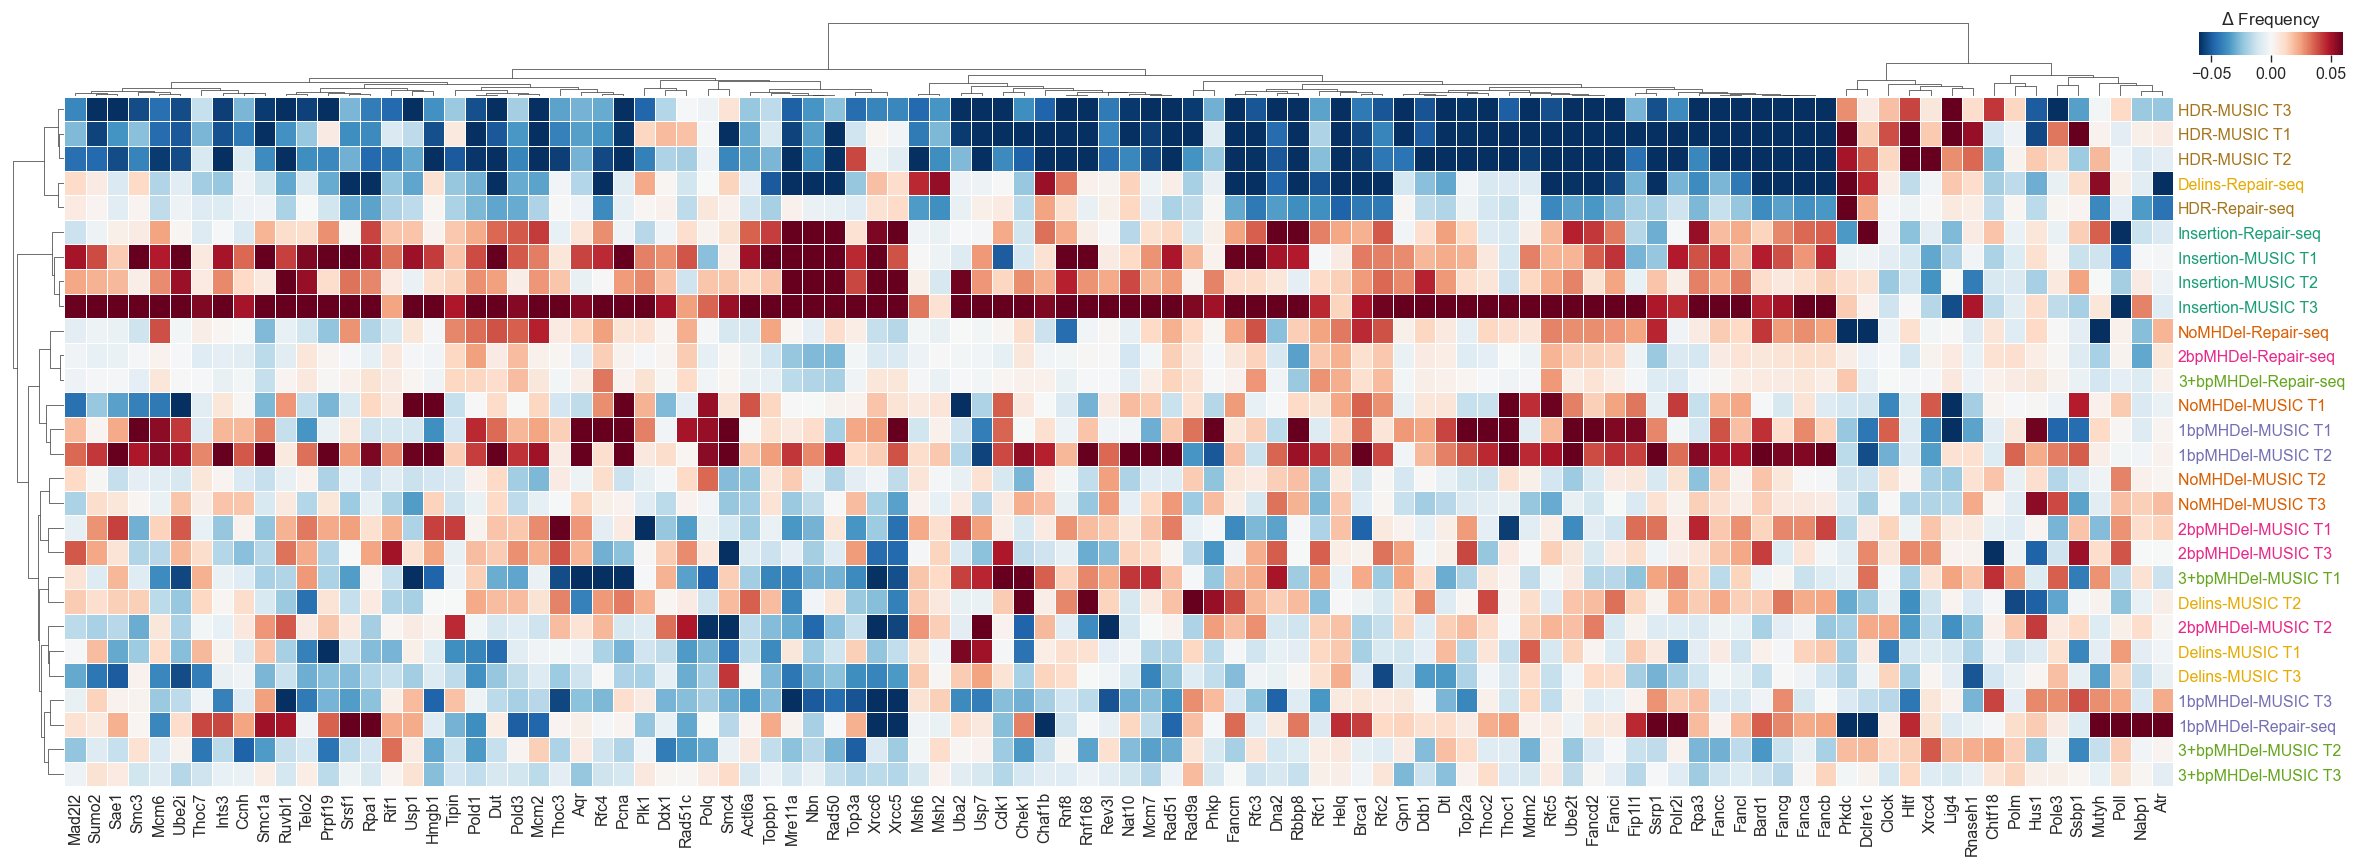

In [26]:
Xpseudodiff.columns = Xpseudodiff.columns.rename(["Target", "Mutational Outcome"])
Xpseudodiff = Xpseudodiff.rename(columns=rename_mutations)
Xpseudodiff = Xpseudodiff.loc[top_genes, :]

pal = sns.color_palette('Dark2', Xpseudodiff.columns.get_level_values("Mutational Outcome").unique().shape[0])
lut = dict(zip(Xpseudodiff.columns.get_level_values("Mutational Outcome").unique(), pal))
col_colors = Xpseudodiff.columns.get_level_values("Mutational Outcome").to_series().map(lut)

cg = sns.clustermap(Xpseudodiff.T.reorder_levels(axis=0, order=[1,0]),
                    metric="correlation",
                    method="ward",
                    figsize=(24, 9),
                    center=0,
                    dendrogram_ratio=(.025, .1),
                    cmap="RdBu_r",
                    vmax=0.06,
                    vmin=-0.06,
                    linewidths=.5,
                    linecolor='white',
                    cbar_pos=(0.92, 0.94, 0.06, 0.025),
                    cbar_kws=dict(orientation='horizontal'),
                    )
cg.ax_heatmap.tick_params(axis='both', which='both', length=0)
cg.ax_heatmap.set_xlabel(None)
cg.ax_heatmap.set_ylabel(None)
cg.ax_heatmap.set_xticklabels(cg.ax_heatmap.get_xmajorticklabels())
cg.ax_heatmap.set_yticklabels(cg.ax_heatmap.get_ymajorticklabels())

cg.ax_cbar.set_title('$\Delta$ Frequency')

for i, tick_label in enumerate(cg.ax_heatmap.axes.get_yticklabels()):
    tick_text = tick_label.get_text().split("-", 1)[0]
    tick_label.set_color(lut[tick_text])
    tick_label.set_rotation(0)

for i, tick_label in enumerate(cg.ax_heatmap.axes.get_xticklabels()):
    tick_label.set_rotation(90)
# ttl = cg.ax_col_dendrogram.set_title("Heatmap to top 100 genes across repair-seq and MUSIC", fontsize=24)
plt.tight_layout()
plt.savefig("artifacts/clustermap.pdf", bbox_inches='tight')